# Top tagging model with ResNet-50 

This is a training script about using top tagging data to train a ResNet-50 Neuron Network. <br>
The training is base on Keras and using tensorflow backend to run.

## Import necessary package and do gpu test.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import hdf5plugin 
import h5py 
import os
from keras.utils import np_utils
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPU


## Input data with H5py package
Input data size: 1 channel image with shape 224x224. <br>
Input label size: 1 or 0 with onehot encoding. <br>
\# of input data(train(with val), test): 30000,6000

In [2]:
img = []
label = []
prefix = "/home/david/ResNet-50-Keras/data/"
train_file = "train/train_file_"
#test_file = "test/test_file_"
#val_file = "val/val_file_"
file_type = ".h5"
path = []
filename = ''
def get_data():
    for i in range(1,4):
        seq =  (train_file, str(i),file_type)
        path = os.path.join(prefix, filename.join(seq))
        with h5py.File(path,'r') as f:
            pt_ = f['img_pt']
            label_ = f['label']
            for a in range(len(pt_)):
                img.append(pt_[a])
            for b in range(len(label_)):
                label.append(label_[b])  
    return np.asanyarray(img), np.asanyarray(label)
    
img, label_ = get_data()
"""
for i in range(0,1):
    seq =  (test_file, str(i),file_type)
    path = os.path.join(prefix, filename.join(seq))
    with h5py.File(path,'r') as f :
        pt_ = f['img_pt']
        label_ = f['label']
        for a in range(0,2000):
            test_img_pt.append(pt_[a])
        for b in range(0,2000):
            test_label_.append(label_[b])

            
for i in range(0,1):
    seq =  (val_file, str(i),file_type)
    path = os.path.join(prefix, filename.join(seq))
    with h5py.File(path,'r') as f :
        pt_ = f['img_pt']
        label_ = f['label']
        for a in range(0,2000):
            val_img_pt.append(pt_[a])
        for b in range(0,2000):
            val_label_.append(label_[b])
"""

"\nfor i in range(0,1):\n    seq =  (test_file, str(i),file_type)\n    path = os.path.join(prefix, filename.join(seq))\n    with h5py.File(path,'r') as f :\n        pt_ = f['img_pt']\n        label_ = f['label']\n        for a in range(0,2000):\n            test_img_pt.append(pt_[a])\n        for b in range(0,2000):\n            test_label_.append(label_[b])\n\n            \nfor i in range(0,1):\n    seq =  (val_file, str(i),file_type)\n    path = os.path.join(prefix, filename.join(seq))\n    with h5py.File(path,'r') as f :\n        pt_ = f['img_pt']\n        label_ = f['label']\n        for a in range(0,2000):\n            val_img_pt.append(pt_[a])\n        for b in range(0,2000):\n            val_label_.append(label_[b])\n"

In [3]:
print((255*img/img.max()).max(), (255*img/img.max()).min())

255.0 0.0


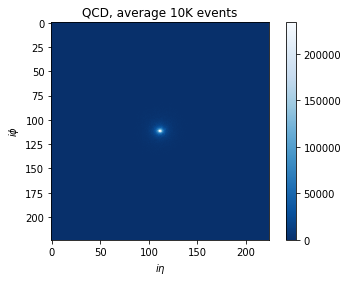

In [4]:
qq, c1, c2, tt = 0, 0, 0, 0 
for i in range(len(img)): 
    if (np.argmax(label[i]) == 1):
        qq += 255*img[i]/img[i].max()
        c1 += 1
    else :
        tt += 255*img[i]/img[i].max()
        c2 +=1
plt.figure()        
color_map = plt.imshow(qq)
color_map.set_cmap("Blues_r")
plt.colorbar()
plt.xlabel(r'$i\eta$')
plt.ylabel(r'$i\phi$')
plt.title('QCD, average 10K events')
plt.savefig("qcd.png")

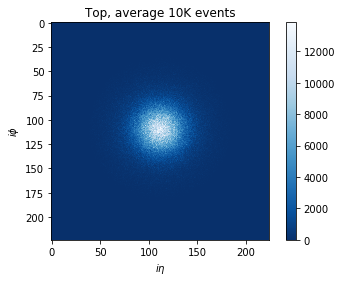

In [5]:
plt.figure()
color_map = plt.imshow(tt)
color_map.set_cmap("Blues_r")
plt.colorbar()
plt.xlabel(r'$i\eta$')
plt.ylabel(r'$i\phi$')
plt.title('Top, average 10K events')
plt.savefig("top.png")
qq, c1, c2, tt = 0, 0, 0, 0 

## Define function to do normalize and duplicate image to 3 channel. <br>
Image will be normalize to 0~255 and duplicate into 3 channel.

In [6]:
def normalize_and_rgb(images, label):  
    #normalize image to 0-255 per image.
    image_sum = 1/np.sum(np.sum(images,axis=1),axis=-1)
    given_axis = 0
    # Create an array which would be used to reshape 1D array, b to have 
    # singleton dimensions except for the given axis where we would put -1 
    # signifying to use the entire length of elements along that axis  
    dim_array = np.ones((1,images.ndim),int).ravel()
    dim_array[given_axis] = -1
    # Reshape b with dim_array and perform elementwise multiplication with 
    # broadcasting along the singleton dimensions for the final output
    image_sum_reshaped = image_sum.reshape(dim_array)
    images = images*image_sum_reshaped*255

    # make it rgb by duplicating 3 channels.
    images = np.stack([images, images, images],axis=-1)
    
    return images, label

image, label = normalize_and_rgb(img, label)


In [7]:
image.shape

(30000, 224, 224, 3)

In [8]:
train_img, train_label = [], []
test_img, test_label = [], []
val_img, val_label = [], []
def arrange_data():
    for i in range(0, 20000):
        train_img.append(image[i])
        train_label.append(label[i])
    for i in range(20000,22000):
        val_img.append(image[i])
        val_label.append(label[i])
    for i in range(22000,24000):
        test_img.append(image[i])
        test_label.append(label[i])
    return np.asanyarray(train_img), np.asanyarray(train_label), np.asanyarray(val_img), np.asanyarray(val_label), np.asanyarray(test_img), np.asanyarray(test_label)
train_img, train_label, val_img, val_label, test_img, test_label = arrange_data()

In [9]:
print(train_img.shape, val_img.shape, test_img.shape)  

(20000, 224, 224, 3) (2000, 224, 224, 3) (2000, 224, 224, 3)


## Construsting a sequential 
Construst a model with Keras pre-configured ResNet-50 and one Dense layer with Softmax activation function. <br>
Using Earlystopping and custom callback function to prevent training from overfitting and collect ROC/AUC data point. 

In [10]:
import datetime
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

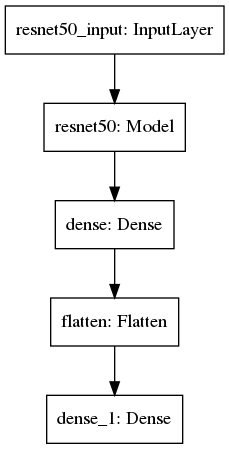

In [11]:
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

def create_model():
    model = tf.keras.models.Sequential([
    tf.keras.applications.ResNet50(weights=None, pooling='max',classes=2048),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax'),
    ])
    return model
model = create_model()
plot_model(model, to_file='Sequential_Model.png')

Image('Sequential_Model.png')

In [12]:
def train_model():
    model = create_model()
    model.load_weights=('../aws-fpga-top-tagging-notebooks/dataset_Tom/weights-floatingpoint-224x224-fixval-best/class_weights.h5')
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC()])
    logdir = os.path.join("logs","fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_graph=True, write_images=True, )
    train_history = model.fit(x=train_img, y=train_label, epochs=10, batch_size=64,validation_data=(val_img, val_label), shuffle=True, callbacks=[tensorboard_callback])
    model.summary()
    return train_history, model
train_history, model = train_model()

Train on 20000 samples, validate on 2000 samples
Epoch 1/10
20000/20000 [==============================] - 117s 6ms/sample - loss: 0.3811 - auc: 0.9043 - val_loss: 1.3960 - val_auc: 0.5000
Epoch 2/10
20000/20000 [==============================] - 108s 5ms/sample - loss: 0.3098 - auc: 0.9355 - val_loss: 2.3215 - val_auc: 0.5000
Epoch 3/10
20000/20000 [==============================] - 109s 5ms/sample - loss: 0.3053 - auc: 0.9395 - val_loss: 1.9618 - val_auc: 0.5000
Epoch 4/10
20000/20000 [==============================] - 109s 5ms/sample - loss: 0.2964 - auc: 0.9416 - val_loss: 1.1731 - val_auc: 0.6805
Epoch 5/10
20000/20000 [==============================] - 109s 5ms/sample - loss: 0.2984 - auc: 0.9403 - val_loss: 2.2963 - val_auc: 0.5000
Epoch 6/10
20000/20000 [==============================] - 109s 5ms/sample - loss: 0.2878 - auc: 0.9456 - val_loss: 2.1783 - val_auc: 0.5000
Epoch 7/10
20000/20000 [==============================] - 109s 5ms/sample - loss: 0.2816 - auc: 0.9477 - val_lo

## Define function to visualize learning curve and prediction. <br><br>

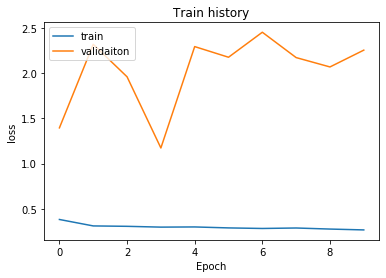

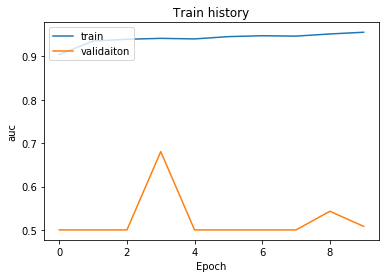

In [13]:
#Define a function to show training history
def show_train_history(train_history, train, validation,filename):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history')
    plt.xlabel('Epoch')
    plt.ylabel(train)
    plt.legend(['train','validaiton'],loc='upper left')
    plt.savefig(filename)
    plt.show()


    
#Show the result of training 
show_train_history(train_history,'loss','val_loss','./loss_new.png')
show_train_history(train_history,'auc','val_auc',filename='./loss_new.png')


In [14]:
def plot_images_prediction(iamges, labels, prediction, idx, num = 10):
    fig = plt.gcf()
    fig.set_size_inches(12,14)
    if num>25: num=25
    for i in range(0,num):
        ax=plt.subplot(5,5,1+i)
        ax.imshow(iamges[idx], cmap='binary')
        title = "label=" + str(np.argmax(labels[idx]))
        if len(prediction)>0 :
            title += ",prediction=" + str(np.argmax(prediction[idx]))
        ax.set_title(title,fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx+=1
    plt.savefig(filename)
    plt.show()

In [15]:
def plot_roc_curve(fpr,tpr,filename): 
    x = np.linspace(0,1)
    y = x
    plt.plot(fpr,tpr,label='model')
    plt.plot(x,y,label='random')
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.savefig(filename)
    plt.show() 

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.00988893 0.99011105]
 [0.00988893 0.99011105]
 [0.00988893 0.99011105]
 ...
 [0.00988893 0.99011105]
 [0.00988893 0.99011105]
 [0.00988893 0.99011105]]


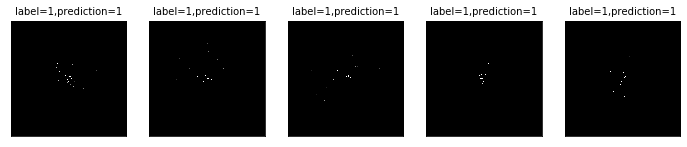

Not a good model, please try again.


In [16]:
from sklearn.metrics import roc_curve,roc_auc_score

#Scoring the accuracy of model by test dataset.
score = model.evaluate(test_img, test_label)
print()
print("Accuracy of model is", score[1])


#Prediction 
prediction = model.predict(test_img)
print(prediction)
test_label_wo_onehot = np.zeros(len(test_label))
pred = np.zeros(len(test_label))
for i in range(len(test_label)):
    test_label_wo_onehot[i] = np.argmax(test_label[i])
#    pred[i] = np.argmax(prediction[i])

plot_images_prediction(test_img,test_label, prediction,idx=1,num=5)


modelname = ""


    
if (score[1] > 0.85):
    path = os.path.join("model","best", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),)
    seq = (path, "my_weight_best_new.h5")
    model.save_weights(modelname.join(seq))
    model.save('./model/my_model_best_new.h5')
    print('A best model was saved.')
    fpr , tpr , thresholds = roc_curve ( test_label_wo_onehot  , pred )   
    plot_roc_curve(fpr,tpr,'./roc_new_best.png') 
    auc_score = roc_auc_score(test_label_wo_onehot, pred)
    print(auc_score)
elif (score[1] > 0.75) and (score[1] < 0.85):
    path = os.path.join("model","better",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),)
    seq = (path, "my_weight_better_new.h5")
    model.save_weights(modelname.join(seq))
    model.save('./model/my_model_better_new.h5')
    print('A better model was saved.')
    fpr , tpr , thresholds = roc_curve ( test_label_wo_onehot  , pred )
    plot_roc_curve(fpr,tpr,'./roc_new_better.png') 
    auc_score = roc_auc_score(test_label_wo_onehot, pred)
    print(auc_score)
else:
    print('Not a good model, please try again.')



In [17]:
#Display confusion matrix
pd.crosstab(test_label_wo_onehot, pred, rownames=['label'], colnames=['predict'])

predict,0.0
label,
0.0,1030
1.0,970


In [18]:
#Display true value and predict value 
df = pd.DataFrame({'label':test_label_wo_onehot,'predict':pred})
df[:10]
#Find the result that true value is x but pred value is y (x != y)
#df[(df.label==1)&(df.predict==0)]

,label,predict
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


## Loading pre-trained model and test 

In [19]:
from sklearn.metrics import roc_curve,roc_auc_score
from tensorflow.keras.models import load_model
model_best = load_model('best_model/my_model_best.h5')
model_best.summary()

model_best.load_weights('best_model/my_weight_best.h5')





Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              27784064  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 29,884,290
Trainable params: 29,831,170
Non-trainable params: 53,120
_________________________________________________________________


640/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Accuracy of model is 0.8734375


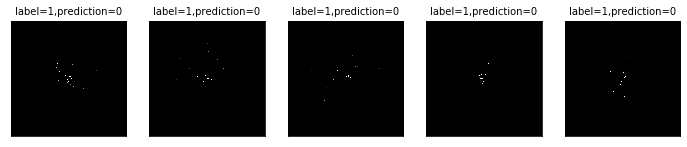

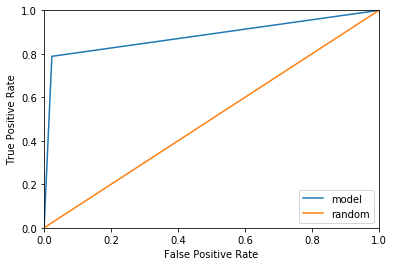

0.8826794114703234


In [20]:
best_prediction = model_best.predict(test_img)

best_score = model_best.evaluate(test_img, test_label,batch_size=64, steps=10)
print()
print("Accuracy of model is", best_score[1])
test_label_wo_onehot = np.zeros(len(test_label))
best_pred = np.zeros(len(test_label))
for i in range(len(test_label)):
    test_label_wo_onehot[i] = np.argmax(test_label[i])
    best_pred[i] = np.argmax(best_prediction[i])
plot_images_prediction(test_img, test_label, best_pred,idx=1,num=5)
best_fpr , best_tpr , best_thresholds = roc_curve (test_label_wo_onehot, best_pred )   
plot_roc_curve(best_fpr, best_tpr,'./roc_best.png') 
best_auc_score = roc_auc_score(test_label_wo_onehot, best_pred)
print(best_auc_score)